# <center> Most Expensive Neighborhoods and Areas in Berlin </center>
### <center> Dr. Lei Zhang </center>
![Berlin: arm aber sexy](berlin.jpg)

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find out where in Berlin have the highest rent *in the next a few years*. Specifically, this report will be targeted to stakeholders interested in investing an appartment house in Berlin, Germany.

We will try to detect **locations that currently have the highest rent** as well as **locations that have or are expected to have the fastest rent growth**. 

We will use our data to generate a few most promissing neighborhoods and areas based on these criteria. A ranking list of the regions will be provided and the perspectives will be analysed,  so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* the current regional average monthly rents per square meter for an apartment exclusive of heating and other additional costs in neighborhoods/areas of Berlin;
* the growth of the regional average monthly rents per square meter for an apartment exclusive of heating and other additional costs in neighborhoods/areas of Berlin.

While it is easy to find out the average rent for each borough, it is not easy to find out the average rent of a specific area, e.g. the average rent within a radius of 500 m from Berlin-Alexanderplatz. Also it is relatively easy to collect data showing the growth of the average rent of each borough over the years, but it is not easy to get those data for each neighborhood/area. We are going to analyse the collected data for Berlin boroughs and some indirectly related data for the neighborhoods and areas to estimate the more specific rents and their growth. 

Following data sources will be needed to extract/generate the desired information:
* general information about Berlin boroughs and neighborhoods will be exacted from the Wikipedia site [Verwaltungsgliederung Berlins](https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins) through web scraping;
* everage rent of each borough of Berlin from 2009 to 2020 will be extracted from pdf documents on the government website [Berliner Wohnungsmarktbericht](https://www.stadtentwicklung.berlin.de/wohnen/wohnungsmarktbericht/);
* demographic data about the population of each borough of Berlin from 2010 to 2019 will be extracted from pdf documents on the government website [Berliner Wohnungsmarktbericht](https://www.stadtentwicklung.berlin.de/wohnen/wohnungsmarktbericht/);
* coordinate of Berlin center and the center of each borough of Berlin will be obtained using the **Nominatim API**;
* **FourSquare API** will be used to get the details and types of venues in the vicinity of a neighborhood of Berlin.

### General Information about Boroughs and Neighborhoods of Berlin

Let's start with installing the necessary packages that we are going to use later on.

In [3]:
# !pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# !pip install folium
import folium # map rendering library
from bs4 import BeautifulSoup # this module helps in web scraping.
import requests  # this module helps us to download a web page
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import linear_model
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from folium import plugins
from folium.plugins import HeatMap

Then we can start webscraping. We'll get some general information about boroughs and neighborhoods of Berlin by scraping the Wikipedia site [Verwaltungsgliederung Berlins](https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins).

In [4]:
url = 'https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins'
data  = requests.get(url).text 
soup = BeautifulSoup(data, 'html5lib')
table = soup.find('table')
table_rows = table.find_all('tr')
table_contents=[]
for i in range(1,len(table_rows)):
    row = table_rows[i].findAll('td')
    cell = {}
    cell['Borough'] = row[1].b.span.text.strip('\n')
    if i < 10:
         cell['Neighborhood'] = row[2].text.replace('0'+str(i)+'01 ','').replace('0'+str(i)+'02 ',', ').replace('0'+str(i)+'03 ',', ').replace('0'+str(i)+'04 ',', ').replace('0'+str(i)+'05 ',', ').replace('0'+str(i)+'06 ',', ').replace('0'+str(i)+'07 ',', ').replace('0'+str(i)+'08 ',', ').replace('0'+str(i)+'09 ',', ').replace('0'+str(i)+'10 ',', ').replace('0'+str(i)+'11 ',', ').replace('0'+str(i)+'12 ',', ').replace('0'+str(i)+'13 ',', ').replace('0'+str(i)+'14 ',', ').replace('0'+str(i)+'15 ',', ').strip('\n')
    else:
         cell['Neighborhood'] = row[2].text.replace(str(i)+'01 ','').replace(str(i)+'02 ',', ').replace(str(i)+'03 ',', ').replace(str(i)+'04 ',', ').replace(str(i)+'05 ',', ').replace(str(i)+'06 ',', ').replace(str(i)+'07 ',', ').replace(str(i)+'08 ',', ').replace(str(i)+'09 ',', ').replace(str(i)+'10 ',', ').replace(str(i)+'11 ',', ').replace(str(i)+'12 ',', ').replace(str(i)+'13 ',', ').replace(str(i)+'14 ',', ').replace(str(i)+'15 ',', ').strip('\n')
    cell['Area'] = row[3].text.strip('\n').replace(',', '')
    cell['Population'] = row[4].text.strip('\n').replace(',', '')
    cell['Density'] = row[5].text.strip('\n').replace(',', '')
    table_contents.append(cell)

# print(table_contents)
df = pd.DataFrame(table_contents)
df[['Population','Area','Density']] = df[['Population','Area','Density']].astype(float)
df

,Borough,Neighborhood,Area,Population,Density
0,Mitte,"Mitte, Moabit, Hansaviertel, Tiergarten, Weddi...",3947.0,385.748,9.773
1,Friedrichshain-Kreuzberg,"Friedrichshain, Kreuzberg",2016.0,290.386,14.404
2,Pankow,"Prenzlauer Berg, Weißensee, Blankenburg, Heine...",10301.0,409.335,3.974
3,Charlottenburg-Wilmersdorf,"Charlottenburg, Wilmersdorf, Schmargendorf, Gr...",6472.0,343.592,5.309
4,Spandau,"Spandau, Haselhorst, Siemensstadt, Staaken, Ga...",9191.0,245.197,2.668
5,Steglitz-Zehlendorf,"Steglitz, Lichterfelde, Lankwitz, Zehlendorf, ...",10250.0,310.071,3.025
6,Tempelhof-Schöneberg,"Schöneberg, Friedenau, Tempelhof, Mariendorf, ...",5309.0,350.984,6.611
7,Neukölln,"Neukölln, Britz, Buckow, Rudow, Gropiusstadt",4493.0,329.917,7.343
8,Treptow-Köpenick,"Alt-Treptow, Plänterwald, Baumschulenweg, Joha...",16842.0,273.689,1.625
9,Marzahn-Hellersdorf,"Marzahn, Biesdorf, Kaulsdorf, Mahlsdorf, Helle...",6174.0,269.967,4.373


Let's get of the rent of each borough of Berlin from 2009 to 2020 from the pdf files on the website [Berliner Wohnungsmarktbericht](https://www.stadtentwicklung.berlin.de/wohnen/wohnungsmarktbericht/).

In [5]:
Berlin = df.append({'Borough':'Berlin'},ignore_index=True).Borough.values.tolist()
Bezirke = Berlin[:]
Bezirke.remove('Berlin')

In [4]:
Berlin_Mieten = pd.DataFrame([[13.70, 13.11, 10.50, 12.38, 8.53, 10.31, 9.97, 9.38, 10.19, 8.02, 9.08, 8.84, 10.14],
                      [13.45, 13.01, 10.96, 12.63, 8.86, 10.70, 10.52, 10.10, 9.93, 7.90, 9.27, 9.42, 10.45],
                      [12.51, 12.94, 10.97, 12.00, 8.59, 10.44, 10.30, 10.00, 9.62, 7.77, 9.53, 9.17, 10.32],
                      [12.77, 12.50, 10.86, 11.86, 7.95, 10.00, 9.97, 10.00, 9.16, 7.16, 9.72, 8.73, 10.15],
                      [10.51, 11.50, 9.99, 10.53, 7.35, 9.38, 9.00, 9.00, 8.24, 6.51, 8.80, 8.00, 9.07],
                      [10.06, 10.99, 9.45, 10.00, 6.99, 8.87, 8.50, 8.57, 7.81, 5.76, 8.10, 7.50, 8.80],
                      [9.36, 9.98, 8.99, 9.49, 6.58, 8.50, 8.01, 7.73, 7.12, 5.80, 7.50, 6.92, 8.25],
                      [9.39, 9.64, 8.56, 9.86, 6.48, 8.50, 8.00, 7.33, 7.08, 5.55, 7.01, 6.86, 8.05],
                      [8.03, 8.61, 8.00, 8.93, 5.93, 7.99, 7.49, 6.70, 6.55, 5.08, 6.53, 6.31, 7.40],
                      [6.18, 7.00, 6.73, 7.53, 5.28, 6.88, 6.23, 5.57, 5.80, 4.85, 5.65, 5.49, 6.17],
                      [5.37, 6.42, 6.13, 6.56, 5.26, 6.29, 5.84, 5.19, 5.55, 4.86, 5.51, 5.26, 5.82]],
                      columns=Berlin)
Berlin_Mieten['Year'] = [2020-i for i in range(0,9)]+[2010,2009]
new_columns = ['Year'] + Berlin
Berlin_Mieten = Berlin_Mieten[new_columns].sort_values(['Year'],ascending=True).reset_index(drop=True)
Berlin_Mieten

,Year,Mitte,Friedrichshain-Kreuzberg,Pankow,Charlottenburg-Wilmersdorf,Spandau,Steglitz-Zehlendorf,Tempelhof-Schöneberg,Neukölln,Treptow-Köpenick,Marzahn-Hellersdorf,Lichtenberg,Reinickendorf,Berlin
0,2009,5.37,6.42,6.13,6.56,5.26,6.29,5.84,5.19,5.55,4.86,5.51,5.26,5.82
1,2010,6.18,7.00,6.73,7.53,5.28,6.88,6.23,5.57,5.80,4.85,5.65,5.49,6.17
2,2012,8.03,8.61,8.00,8.93,5.93,7.99,7.49,6.70,6.55,5.08,6.53,6.31,7.40
3,2013,9.39,9.64,8.56,9.86,6.48,8.50,8.00,7.33,7.08,5.55,7.01,6.86,8.05
4,2014,9.36,9.98,8.99,9.49,6.58,8.50,8.01,7.73,7.12,5.80,7.50,6.92,8.25
5,2015,10.06,10.99,9.45,10.00,6.99,8.87,8.50,8.57,7.81,5.76,8.10,7.50,8.80
6,2016,10.51,11.50,9.99,10.53,7.35,9.38,9.00,9.00,8.24,6.51,8.80,8.00,9.07
7,2017,12.77,12.50,10.86,11.86,7.95,10.00,9.97,10.00,9.16,7.16,9.72,8.73,10.15
8,2018,12.51,12.94,10.97,12.00,8.59,10.44,10.30,10.00,9.62,7.77,9.53,9.17,10.32
9,2019,13.45,13.01,10.96,12.63,8.86,10.70,10.52,10.10,9.93,7.90,9.27,9.42,10.45


Let's take a preview of the data.

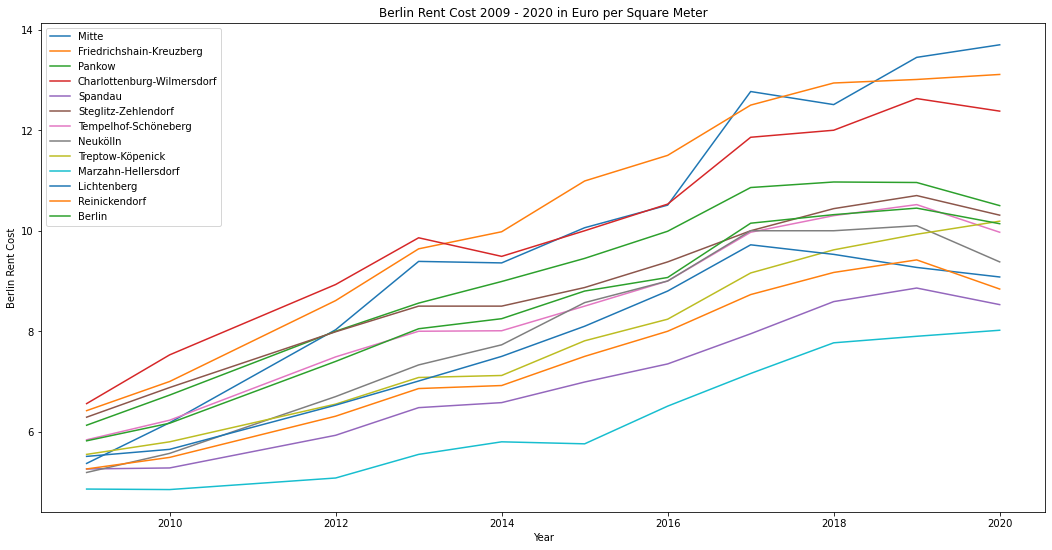

In [5]:
plt.figure(figsize = (18,9))
plt.plot(Berlin_Mieten['Year'], Berlin_Mieten[Berlin])
plt.title('Berlin Rent Cost 2009 - 2020 in Euro per Square Meter')
plt.xlabel('Year')
plt.ylabel('Berlin Rent Cost')
plt.legend(Berlin)
plt.show()

The green line is the average rent of the whole of Berlin. Apparently, the three Boroughs Berlin-Mitte, Berlin-Friedrichshain-Kreuzberg, Berlin-Charlottenburg-Wilmersdorf are above average, and the others are below average.

Now let's collect the demographic data about the population of each borough of Berlin from 2010 to 2019 from the same source.

In [6]:
Year = [2010+i for i in range(0,10)]
Berlin_Einwohner = pd.DataFrame([[326650, 333152, 339974, 348102, 356506, 363236, 371407, 377965, 383457, 385748],
                      [261090, 265361, 269471, 273517, 275691, 278393, 281323, 283974, 289120, 290386],
                      [360017, 365021, 370937, 377532, 384367, 389976, 397406, 402289, 407289, 409335],
                      [312340, 314911, 319289, 322870, 326354, 330468, 336249, 338831, 341327, 343592],
                      [218094, 220645, 223305, 226868, 230419, 234630, 239942, 242143, 243080, 245197],
                      [291700, 293692, 295746, 298200, 299268, 299765, 304086, 307076, 308077, 310071],
                      [329245, 329361, 328428, 331822, 335767, 341161, 346108, 348739, 351429, 350984],
                      [307204, 313245, 318356, 322153, 325716, 328062, 327522, 329387, 330786, 329917],
                      [239374, 241487, 243844, 245951, 249440, 253333, 259524, 264999, 269775, 273689],
                      [246225, 249232, 251879, 254226, 256173, 259373, 262015, 266684, 268739, 269967],
                      [253539, 256280, 260505, 264858, 268465, 275142, 283121, 286246, 290493, 294201],
                      [242084, 244727, 247887, 251325, 254000, 256617, 261919, 263597, 264826, 266408]],
                      columns=Year)
Berlin_Einwohner = pd.DataFrame(Berlin_Einwohner.T.values, columns=Bezirke)
Berlin_Einwohner['Year'] = Year
new_columns = ['Year'] + Bezirke
Berlin_Einwohner = Berlin_Einwohner[new_columns].sort_values(['Year'],ascending=True).reset_index(drop=True)
Berlin_Einwohner

,Year,Mitte,Friedrichshain-Kreuzberg,Pankow,Charlottenburg-Wilmersdorf,Spandau,Steglitz-Zehlendorf,Tempelhof-Schöneberg,Neukölln,Treptow-Köpenick,Marzahn-Hellersdorf,Lichtenberg,Reinickendorf
0,2010,326650,261090,360017,312340,218094,291700,329245,307204,239374,246225,253539,242084
1,2011,333152,265361,365021,314911,220645,293692,329361,313245,241487,249232,256280,244727
2,2012,339974,269471,370937,319289,223305,295746,328428,318356,243844,251879,260505,247887
3,2013,348102,273517,377532,322870,226868,298200,331822,322153,245951,254226,264858,251325
4,2014,356506,275691,384367,326354,230419,299268,335767,325716,249440,256173,268465,254000
5,2015,363236,278393,389976,330468,234630,299765,341161,328062,253333,259373,275142,256617
6,2016,371407,281323,397406,336249,239942,304086,346108,327522,259524,262015,283121,261919
7,2017,377965,283974,402289,338831,242143,307076,348739,329387,264999,266684,286246,263597
8,2018,383457,289120,407289,341327,243080,308077,351429,330786,269775,268739,290493,264826
9,2019,385748,290386,409335,343592,245197,310071,350984,329917,273689,269967,294201,266408


Again, a preview to get a quick impression.

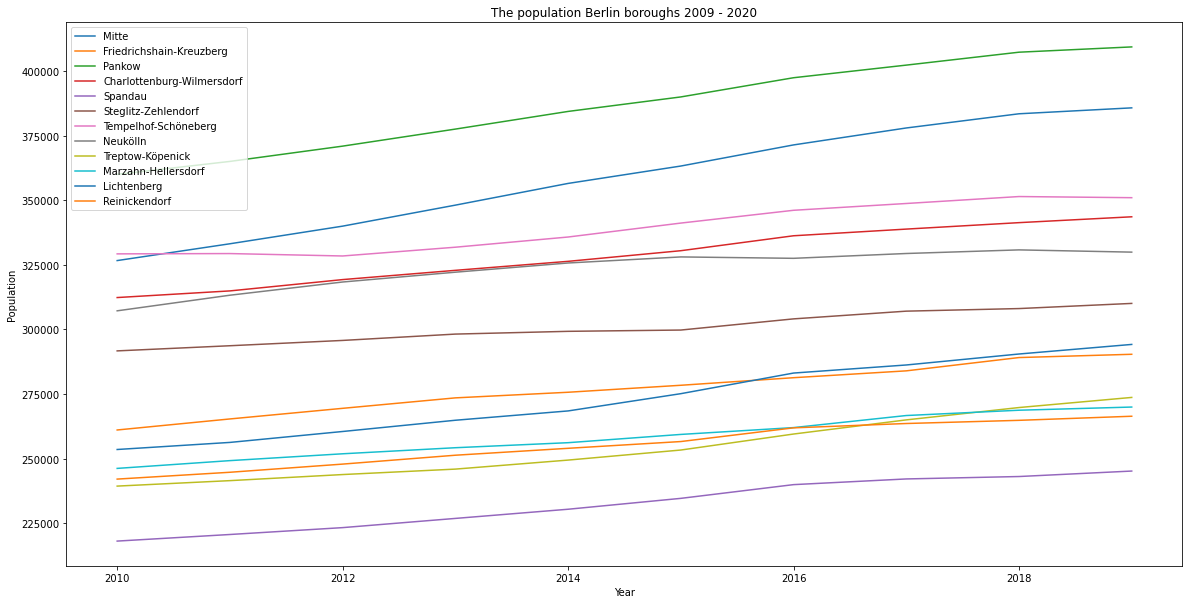

In [7]:
plt.figure(figsize = (20,10))
plt.plot(Berlin_Einwohner['Year'], Berlin_Einwohner[Bezirke])
plt.title('The population Berlin boroughs 2009 - 2020')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(Berlin)
plt.show()

### City, Borough, Neighborhood Coordinates

Let's get latitude & longitude coordinates of the center of Berlin and the center of each borough of Berlin using the **Nominatim API** and store them into a Pandas DataFrame. 

In [8]:
geolocator = Nominatim(user_agent="ny_explorer")
Coordinates = []
for i in range(0,len(Berlin)):
                 location = geolocator.geocode(Berlin[i]+', Berlin')
                 latitude = location.latitude
                 longitude = location.longitude
                 Coordinates.append({'Borough':Berlin[i], 'Latitude':latitude, 'Longitude':longitude})
Coordinates = pd.DataFrame(Coordinates)
Coordinates

,Borough,Latitude,Longitude
0,Mitte,52.517885,13.404060
1,Friedrichshain-Kreuzberg,52.501115,13.444285
2,Pankow,52.597917,13.435316
3,Charlottenburg-Wilmersdorf,52.507856,13.263952
4,Spandau,52.535788,13.197792
5,Steglitz-Zehlendorf,52.429205,13.229974
6,Tempelhof-Schöneberg,52.440603,13.373703
7,Neukölln,52.481150,13.435350
8,Treptow-Köpenick,52.417893,13.600185
9,Marzahn-Hellersdorf,52.522523,13.587663


Let's then plot these locations into a map to get an initial impression.

In [9]:
# create map of Toronto using latitude and longitude values
map_berlin = folium.Map(location=Coordinates.iloc[12,[1,2]], zoom_start=11)

# add markers to map
for lat, lng, borough in zip(Coordinates['Latitude'], Coordinates['Longitude'], Coordinates['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    if borough == 'Berlin':
           c = 'red'
    else:
           c = 'blue'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=c,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

The middle red circle is the center of Berlin. It is the crosspoint of **Friedrichstraße** and **Unter den Linden**.

This amplifies our data:

In [10]:
df = df.join(Coordinates.drop(index=12).set_index('Borough'), on='Borough', how='right')
df 

,Borough,Neighborhood,Area,Population,Density,Latitude,Longitude
0,Mitte,"Mitte, Moabit, Hansaviertel, Tiergarten, Weddi...",3947.0,385.748,9.773,52.517885,13.404060
1,Friedrichshain-Kreuzberg,"Friedrichshain, Kreuzberg",2016.0,290.386,14.404,52.501115,13.444285
2,Pankow,"Prenzlauer Berg, Weißensee, Blankenburg, Heine...",10301.0,409.335,3.974,52.597917,13.435316
3,Charlottenburg-Wilmersdorf,"Charlottenburg, Wilmersdorf, Schmargendorf, Gr...",6472.0,343.592,5.309,52.507856,13.263952
4,Spandau,"Spandau, Haselhorst, Siemensstadt, Staaken, Ga...",9191.0,245.197,2.668,52.535788,13.197792
5,Steglitz-Zehlendorf,"Steglitz, Lichterfelde, Lankwitz, Zehlendorf, ...",10250.0,310.071,3.025,52.429205,13.229974
6,Tempelhof-Schöneberg,"Schöneberg, Friedenau, Tempelhof, Mariendorf, ...",5309.0,350.984,6.611,52.440603,13.373703
7,Neukölln,"Neukölln, Britz, Buckow, Rudow, Gropiusstadt",4493.0,329.917,7.343,52.481150,13.435350
8,Treptow-Köpenick,"Alt-Treptow, Plänterwald, Baumschulenweg, Joha...",16842.0,273.689,1.625,52.417893,13.600185
9,Marzahn-Hellersdorf,"Marzahn, Biesdorf, Kaulsdorf, Mahlsdorf, Helle...",6174.0,269.967,4.373,52.522523,13.587663


Now, let's get the coordinates for the neighborhoods. We will only look into the neighborhoods which we are interested in, namely those whose boroughs have an above average rent.

In [11]:
Mitte = list(map(str.strip,df.loc[0,'Neighborhood'].split(',')))
Friedrichshain_Kreuzberg = list(map(str.strip,df.loc[1,'Neighborhood'].split(',')))
Charlottenburg_Wilmersdorf = list(map(str.strip,df.loc[3,'Neighborhood'].split(',')))

In [12]:
Data = []
for x in Mitte+Friedrichshain_Kreuzberg+Charlottenburg_Wilmersdorf:
    if x in Mitte:
        address = x + ', Mitte, Berlin, Germany'
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        Data.append({'Borough':'Mitte', 'Neighborhood':x, 'Latitude':latitude, 'Longitude':longitude})
    elif x in Friedrichshain_Kreuzberg:
        address = x + ', Berlin, Germany'
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        Data.append({'Borough':'Friedrichshain_Kreuzberg', 'Neighborhood':x, 'Latitude':latitude, 'Longitude':longitude}) 
    else:
        address = x + ', Berlin, Germany'
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        Data.append({'Borough':'Charlottenburg_Wilmersdorf', 'Neighborhood':x, 'Latitude':latitude, 'Longitude':longitude}) 

Berlin_Ortsteil = pd.DataFrame(Data)
Berlin_Ortsteil        

,Borough,Neighborhood,Latitude,Longitude
0,Mitte,Mitte,52.517885,13.404060
1,Mitte,Moabit,52.530102,13.342542
2,Mitte,Hansaviertel,52.519123,13.341872
3,Mitte,Tiergarten,52.509778,13.357260
4,Mitte,Wedding,52.550123,13.341970
5,Mitte,Gesundbrunnen,52.550920,13.384846
6,Friedrichshain_Kreuzberg,Friedrichshain,52.512215,13.450290
7,Friedrichshain_Kreuzberg,Kreuzberg,52.497644,13.411914
8,Charlottenburg_Wilmersdorf,Charlottenburg,52.515747,13.309683
9,Charlottenburg_Wilmersdorf,Wilmersdorf,52.487115,13.320330


Again, we will plot the neighborhoods into a map to get some impression.

In [13]:
map_berlin = folium.Map(location=Coordinates.iloc[12,[1,2]], zoom_start=12)

# add markers to map
for lat, lng, ortsteil in zip(Berlin_Ortsteil['Latitude'], Berlin_Ortsteil['Longitude'], Berlin_Ortsteil['Neighborhood']):
    label = '{}'.format(ortsteil)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on the venus in each neighborhood. In particular, we are interested in the nearby hotels.

Foursquare credentials are defined in hidden cell bellow.

In [67]:
CLIENT_ID = '****' # my Foursquare ID
CLIENT_SECRET = '****' # my Foursquare Secret

In [15]:
VERSION = '20210519' # Foursquare API version

LIMIT = 10000 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius

In [16]:
# Category IDs corresponding to hotels were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

hotel_category = '4bf58dd8d48988d1fa931735' # 'Root' category for all hotel-related venues

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
nearby_venues = getNearbyVenues(names=Berlin_Ortsteil['Neighborhood'],
                                   latitudes=Berlin_Ortsteil['Latitude'],
                                   longitudes=Berlin_Ortsteil['Longitude']
                                  )

In [19]:
nearby_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mitte,52.517885,13.40406,"Bronzestatue ""Heiliger St. Georg im Kampf mit ...",52.516290,13.405558,Outdoor Sculpture
1,Mitte,52.517885,13.40406,Designpanoptikum - surreales Museum für indust...,52.516941,13.406072,Museum
2,Mitte,52.517885,13.40406,Kuppelumgang Berliner Dom,52.518966,13.400981,Scenic Lookout
3,Mitte,52.517885,13.40406,Lustgarten,52.518469,13.399454,Garden
4,Mitte,52.517885,13.40406,Tigertörtchen,52.517150,13.407926,Cupcake Shop


In [20]:
nearby_venues.shape

(1159, 7)

In [21]:
nearby_venues['Neighborhood'].value_counts()

Hansaviertel           100
Halensee               100
Kreuzberg              100
Moabit                 100
Friedrichshain         100
Mitte                  100
Wilmersdorf            100
Charlottenburg         100
Tiergarten             100
Gesundbrunnen           85
Wedding                 54
Schmargendorf           39
Westend                 31
Grunewald               30
Charlottenburg-Nord     20
Name: Neighborhood, dtype: int64

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report!

## Methodology <a name="methodology"></a>

The goal of this project is to find out the neighborhoods and areas of Berlin that would have the highest rent in the next a few years. Therefore, two factors are extremely import. One is the current average rent, the other is the expected growth of the rent. From the preliminary look on the data that we have collected, it is clear that currently Berlin-Mitte has the highest average rent - 13.70 EUR every square meter, Berlin-Friedrichshain-Kreuzberg comes with 13.11 EUR the second, and Berlin-Charlottenburg-Wilmersdorf with 12.38 EUR is also above average. Then we will come to the growth. It is quite clear from the line chart that none of the boroughs of Berlin whose average rents are below the Berlin-average could have a chance to climbe up to the top. Thus it is reasonable for us to only focus on these three above mentioned boroughs.

In first step we will use **simple linear regression models** to estimate the growth of the average rent of each of the three boroughs and Berlin as a whole from 2009 to 2020. We visualize the results and put them together to compare. 

The second step of our analysis will be to use **simple linear regression models** to estimate the growth of the population of each of the three boroughs and Berlin as a whole from 2009 to 2020. We also visualize the results and compare them. 

In third step we will create **clusters of locations based on the patterns their nearby venues** (**k-means clustering** and **density-based clustering**) for all the neighborhoods in the three boroughs having in mind that areas with similar patterns of nearby venues should have similar average rent. We will analyse the similarities among each cluster.

In the fourth step we will use the patterns that we discovered to estimite which areas of Berlin should have the highest rent in the next a few years.

In the last step we will use the data collected from [Berliner Mietspiegel](https://www.stadtentwicklung.berlin.de/wohnen/mietspiegel/) to test our estimation.

## Analysis <a name="analysis"></a>

In this simple linear regression model we use the years as independent variable to estimate the dependent variables - the average rent of each borough.

In [22]:
x = np.asanyarray(Berlin_Mieten[['Year']])
y_B = np.asanyarray(Berlin_Mieten[['Berlin']])
y_M = np.asanyarray(Berlin_Mieten[['Mitte']])
y_FK = np.asanyarray(Berlin_Mieten[['Friedrichshain-Kreuzberg']])
y_CW = np.asanyarray(Berlin_Mieten[['Charlottenburg-Wilmersdorf']])
regr_Berlin = linear_model.LinearRegression().fit (x, y_B)
regr_M = linear_model.LinearRegression().fit (x, y_M)
regr_FK = linear_model.LinearRegression().fit (x, y_FK)
regr_CW = linear_model.LinearRegression().fit (x, y_CW)

# The coefficients
print ('Berlin-Coefficients: ', regr_Berlin.coef_)
print ('Berlin-Mitte-Coefficients: ', regr_M.coef_)
print ('Berlin-Friedrichshain-Kreuzberg-Coefficients: ', regr_FK.coef_)
print ('Berlin-Charlottenburg-Wilmersdorf-Coefficients: ', regr_CW.coef_)

Berlin-Coefficients:  [[0.44519635]]
Berlin-Mitte-Coefficients:  [[0.77734222]]
Berlin-Friedrichshain-Kreuzberg-Coefficients:  [[0.65827489]]
Berlin-Charlottenburg-Wilmersdorf-Coefficients:  [[0.5398317]]


Here the coefficients indicate the rate of growth - the higher the number is, the faster it growth.

Let's visualize the result.

Text(0, 0.5, 'Berlin-Charlottenburg-Wilmersdorf Rent')

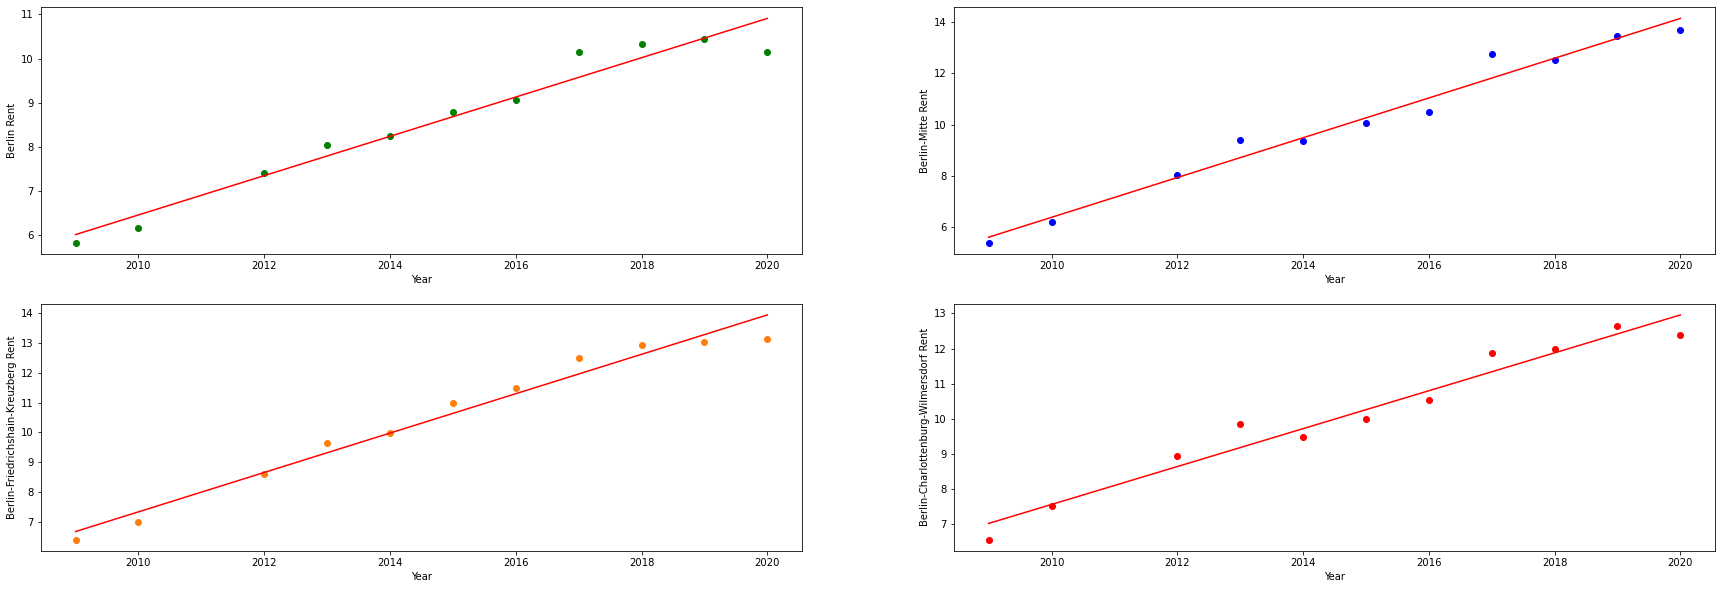

In [23]:
Mietpreisentwicklung = plt.subplots(nrows=2, ncols=2, figsize = (30,10))
fig, ((ax1,ax2),(ax3,ax4)) = Mietpreisentwicklung
ax1.scatter(Berlin_Mieten.Year, Berlin_Mieten.Berlin,  color='green')
ax1.plot(x, regr_Berlin.coef_[0][0]*x + regr_Berlin.intercept_[0], '-r')
ax1.set_xlabel("Year")
ax1.set_ylabel("Berlin Rent")

ax2.scatter(Berlin_Mieten.Year, Berlin_Mieten.Mitte,  color='blue')
ax2.plot(x, regr_M.coef_[0][0]*x + regr_M.intercept_[0], '-r')
ax2.set_xlabel("Year")
ax2.set_ylabel("Berlin-Mitte Rent")

ax3.scatter(Berlin_Mieten.Year, Berlin_Mieten['Friedrichshain-Kreuzberg'],  color='tab:orange')
ax3.plot(x, regr_FK.coef_[0][0]*x + regr_FK.intercept_[0], '-r')
ax3.set_xlabel("Year")
ax3.set_ylabel("Berlin-Friedrichshain-Kreuzberg Rent")

ax4.scatter(Berlin_Mieten.Year, Berlin_Mieten['Charlottenburg-Wilmersdorf'],  color='red')
ax4.plot(x, regr_CW.coef_[0][0]*x + regr_CW.intercept_[0], '-r')
ax4.set_xlabel("Year")
ax4.set_ylabel("Berlin-Charlottenburg-Wilmersdorf Rent")

The models fit the samples quite well and no sign of overfitting. However, since the values only differ marginally, it is hard to compare them visually, even side by side! 

So, let's put them together!

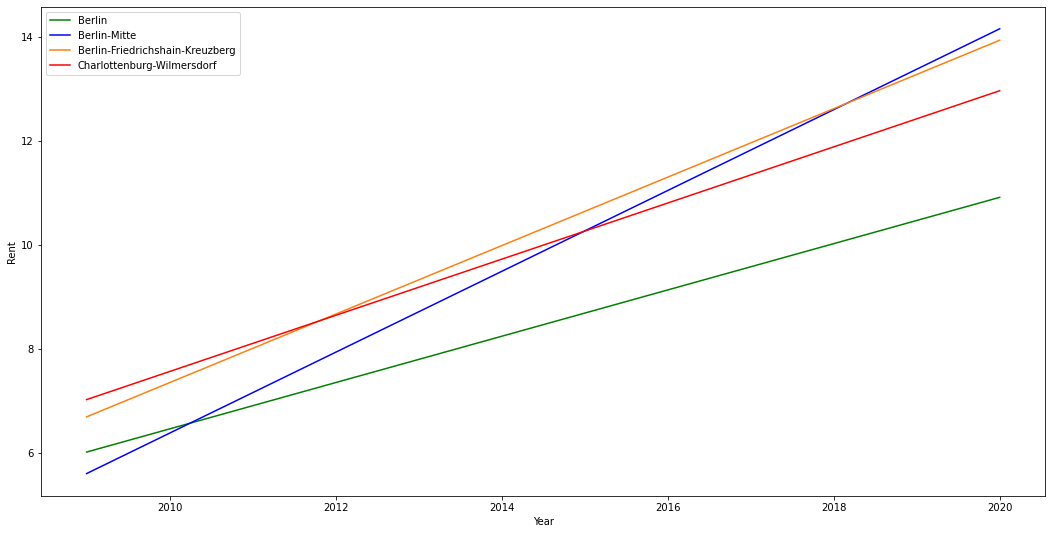

In [24]:
plt.figure(figsize = (18,9))
plt.plot(x, regr_Berlin.coef_[0][0]*x + regr_Berlin.intercept_[0], '-g', label='Berlin')
plt.plot(x, regr_M.coef_[0][0]*x + regr_M.intercept_[0], '-b', label='Berlin-Mitte')
plt.plot(x, regr_FK.coef_[0][0]*x + regr_FK.intercept_[0], 'tab:orange', label='Berlin-Friedrichshain-Kreuzberg')
plt.plot(x, regr_CW.coef_[0][0]*x + regr_CW.intercept_[0], '-r', label='Charlottenburg-Wilmersdorf')
plt.xlabel("Year")
plt.ylabel("Rent")
plt.legend()
plt.show()

Clearly, Berlin-Mitte has not only the highest rent, but also the fastest rent growth! Berlin-Friedrichshain-Kreuzberg in the second place with respect to both current rent and rent growth.

Next, we move to population growth.

In [25]:
x = np.asanyarray(Berlin_Einwohner[['Year']])
y_M = np.asanyarray(Berlin_Einwohner[['Mitte']])
y_FK = np.asanyarray(Berlin_Einwohner[['Friedrichshain-Kreuzberg']])
y_CW = np.asanyarray(Berlin_Einwohner[['Charlottenburg-Wilmersdorf']])
regr_M = linear_model.LinearRegression().fit (x, y_M)
regr_FK = linear_model.LinearRegression().fit (x, y_FK)
regr_CW = linear_model.LinearRegression().fit (x, y_CW)

# The coefficients
print ('Berlin-Mitte-Coefficients: ', regr_M.coef_[0][0])
print ('Berlin-Friedrichshain-Kreuzberg-Coefficients: ',regr_FK.coef_[0][0])
print ('Berlin-Charlottenburg-Wilmersdorf-Coefficients: ', regr_CW.coef_[0][0])

Berlin-Mitte-Coefficients:  6973.436363636361
Berlin-Friedrichshain-Kreuzberg-Coefficients:  3203.7090909090903
Berlin-Charlottenburg-Wilmersdorf-Coefficients:  3685.70303030303


Clearly, Berlin-Mitte has the fastest population growth, and Berlin-Charlottenburg-Wilmersdorf is the second. But here one has to pay attention that population growth is not equal to population density growth, and the latter reflex more about the rent growth. Let's also consider the population density growth by dividing the current data by the areas.

In [26]:
x = np.asanyarray(Berlin_Einwohner[['Year']])
y_M = np.asanyarray(Berlin_Einwohner[['Mitte']]/3947.0)
y_FK = np.asanyarray(Berlin_Einwohner[['Friedrichshain-Kreuzberg']]/2016.0)
y_CW = np.asanyarray(Berlin_Einwohner[['Charlottenburg-Wilmersdorf']]/6472.0)
regr_M2 = linear_model.LinearRegression().fit (x, y_M)
regr_FK2 = linear_model.LinearRegression().fit (x, y_FK)
regr_CW2 = linear_model.LinearRegression().fit (x, y_CW)

# The coefficients
print ('Berlin-Mitte-Coefficients: ', regr_M2.coef_[0][0])
print ('Berlin-Friedrichshain-Kreuzberg-Coefficients: ',regr_FK2.coef_[0][0])
print ('Berlin-Charlottenburg-Wilmersdorf-Coefficients: ', regr_CW2.coef_[0][0])

Berlin-Mitte-Coefficients:  1.7667687772070833
Berlin-Friedrichshain-Kreuzberg-Coefficients:  1.5891414141414126
Berlin-Charlottenburg-Wilmersdorf-Coefficients:  0.5694843989961417


Now our ranking comes back. It is consistent with the ranking of rent growth.

Next, let's visualize the population growth.

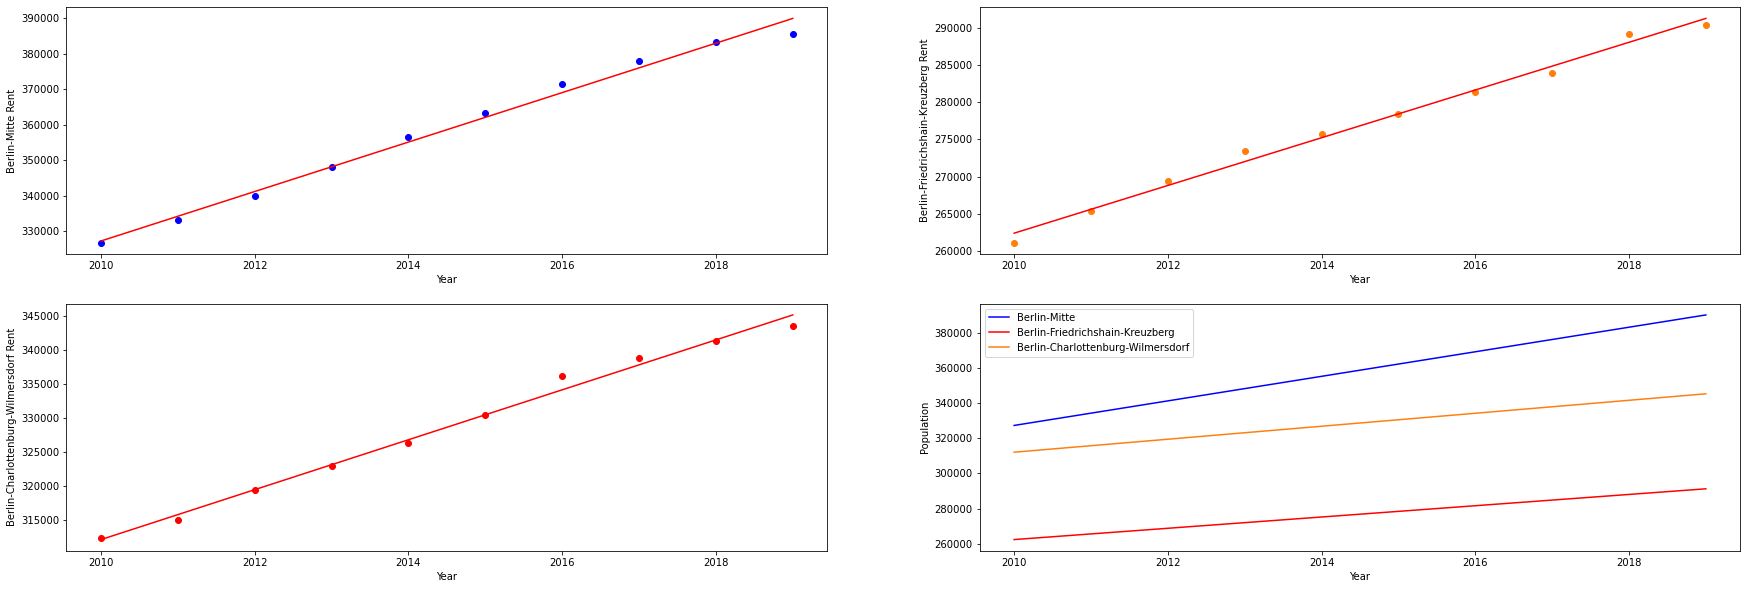

In [27]:
Bevölkerungsentwicklung = plt.subplots(nrows=2, ncols=2, figsize = (30,10))
fig, ((ax1,ax2),(ax3,ax4)) = Bevölkerungsentwicklung 

ax1.scatter(Berlin_Einwohner.Year, Berlin_Einwohner.Mitte,  color='blue')
ax1.plot(x, regr_M.coef_[0][0]*x + regr_M.intercept_[0], '-r')
ax1.set_xlabel("Year")
ax1.set_ylabel("Berlin-Mitte Rent")

ax2.scatter(Berlin_Einwohner.Year, Berlin_Einwohner['Friedrichshain-Kreuzberg'],  color='tab:orange')
ax2.plot(x, regr_FK.coef_[0][0]*x + regr_FK.intercept_[0], '-r')
ax2.set_xlabel("Year")
ax2.set_ylabel("Berlin-Friedrichshain-Kreuzberg Rent")

ax3.scatter(Berlin_Einwohner.Year, Berlin_Einwohner['Charlottenburg-Wilmersdorf'],  color='red')
ax3.plot(x, regr_CW.coef_[0][0]*x + regr_CW.intercept_[0], '-r')
ax3.set_xlabel("Year")
ax3.set_ylabel("Berlin-Charlottenburg-Wilmersdorf Rent")

ax4.plot(x, regr_M.coef_[0][0]*x + regr_M.intercept_[0], '-b', label='Berlin-Mitte')
ax4.plot(x, regr_FK.coef_[0][0]*x + regr_FK.intercept_[0], '-r', label='Berlin-Friedrichshain-Kreuzberg')
ax4.plot(x, regr_CW.coef_[0][0]*x + regr_CW.intercept_[0], 'tab:orange', label='Berlin-Charlottenburg-Wilmersdorf')
ax4.set_xlabel("Year")
ax4.set_ylabel("Population")
ax4.legend()

Now let's use **density-based clustering DBSCAN** to cluster the nearby venues. This clustering is only based on the locations of the venues, not base on the types of the venues. The advantage of DBSCAN is that it is robust against the outliers and you don't have to specify the number *k* which is an important parameter in the k-means clustering.

In [28]:
Clus_dataSet = nearby_venues[['Venue Latitude','Venue Longitude']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
nearby_venues["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
nearby_venues.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Clus_Db
0,Mitte,52.517885,13.40406,"Bronzestatue ""Heiliger St. Georg im Kampf mit ...",52.516290,13.405558,Outdoor Sculpture,0
1,Mitte,52.517885,13.40406,Designpanoptikum - surreales Museum für indust...,52.516941,13.406072,Museum,0
2,Mitte,52.517885,13.40406,Kuppelumgang Berliner Dom,52.518966,13.400981,Scenic Lookout,0
3,Mitte,52.517885,13.40406,Lustgarten,52.518469,13.399454,Garden,0
4,Mitte,52.517885,13.40406,Tigertörtchen,52.517150,13.407926,Cupcake Shop,0


Here are the labels. The venues with label "-1" are the outliers.

In [29]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [30]:
print('The outliers are in: ', end='\n')
for x in nearby_venues[nearby_venues['Clus_Db']==-1].Neighborhood.unique():
    print(x)

The outliers are in: 
Wedding
Schmargendorf
Grunewald
Westend
Charlottenburg-Nord


Let's now visualize the clusters on the maps.

In [31]:
map_berlin = folium.Map(location=Coordinates.iloc[12,[1,2]], zoom_start=12)

print('The clusters and the coordinates of their centroids are: ', end='\n')

# Visualization1
for clust_number in set(labels):
    clust_set = nearby_venues[nearby_venues.Clus_Db == clust_number] 
    
# Set color for the nodes
    x = np.arange(len(set(labels)))
    ys = [i + x + (i*x)**2 for i in range(len(set(labels)))]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    if clust_number != -1:
        cenx=np.mean(clust_set['Venue Latitude']) 
        ceny=np.mean(clust_set['Venue Longitude']) 
        print ("Cluster "+str(clust_number)+', ', end='')
        for i in range(0,len(clust_set.Neighborhood.unique())):
                    print(clust_set.Neighborhood.unique()[i], end=', ')
        print('coordinates: '+ str(cenx) + ', ' + str(ceny)+'.', end='\n')
                  
                    
                    
                
        for x,y in zip(clust_set['Venue Latitude'], clust_set['Venue Longitude']):
                     label = '{}, Cluster {}'.format(clust_set.Neighborhood.unique()[0], clust_number)
                     label = folium.Popup(label, parse_html=True)
                     folium.CircleMarker(
                         [x, y],
                         radius=3,
                         popup=label,
                         color=rainbow[clust_number-1],
                         fill=True,
                         fill_color='#cc3131',
                         fill_opacity=1.7,
                         parse_html=False).add_to(map_berlin)  
                    
        label = '{}, Cluster {}'.format(clust_set.Neighborhood.unique()[0], clust_number)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
                [cenx, ceny],
                radius=3,
                popup=label,
                color='black',
                fill=True,
                fill_color='#cc3131',
                fill_opacity=1.7,
                parse_html=False).add_to(map_berlin) 
        
map_berlin

The clusters and the coordinates of their centroids are: 
Cluster 0, Mitte, coordinates: 52.52022415596093, 13.40376360485069.
Cluster 1, Moabit, Hansaviertel, Tiergarten, Charlottenburg, coordinates: 52.5186084276777, 13.346268722550933.
Cluster 2, Wedding, coordinates: 52.55082119062809, 13.348438845426461.
Cluster 3, Gesundbrunnen, coordinates: 52.55122848288395, 13.383479520616007.
Cluster 4, Friedrichshain, coordinates: 52.51134647226065, 13.453956962818445.
Cluster 5, Kreuzberg, coordinates: 52.498114097915995, 13.416404598823647.
Cluster 6, Charlottenburg, Wilmersdorf, Schmargendorf, Halensee, coordinates: 52.49938592173205, 13.30867343748716.
Cluster 7, Schmargendorf, coordinates: 52.47803669430278, 13.287706600213536.
Cluster 8, Grunewald, coordinates: 52.485954325142174, 13.263261895735477.
Cluster 9, Westend, coordinates: 52.51353499019267, 13.261082077240117.
Cluster 10, Charlottenburg-Nord, coordinates: 52.53666861510058, 13.29063831106081.


The result is no supprising. Since the clustering is based on the locations of the venues, the centroids of the clusters are basically the centroids of the neighborhoods, with expections cluster 1 and cluster 6 where large neighborhoods are clustered together. But we can still read some information out of this clustering: cluster 7,8,9,10 have very few venues in them. In Berlin, this means simply that these are forests. Living in forests can also be expensive, but you would not expect that the rent rises sharply there, because forest stays as forest unless there is a forest fire. Also, neighborhoods with outliers, *i.e.* those who get '-1' in their labels, do not look promising, because in crowded areas, the venues are usually clustered together.

Now let's cluster the venues based on their types. First of all, we should transfer the string values to numeric values in oder to perform analysis.

In [32]:
# one hot encoding
hotspots = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")
print(hotspots.columns.get_loc("Neighborhood"))

# add neighborhood column back to dataframe
hotspots['Neighborhoods'] = nearby_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hotspots.columns[-1]] + list(hotspots.columns[:-1])
hotspots = hotspots[fixed_columns]

hotspots.head(10)

151


,Neighborhoods,ATM,Accessories Store,Adult Boutique,African Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yemeni Restaurant,Yoga Studio,Zoo Exhibit
0,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we take the mean of the values according to each neighborhood to see which kind of venue is more popular in the neighborhood.

In [33]:
grouped_hotspots = hotspots.groupby('Neighborhoods').mean().reset_index()
grouped_hotspots

,Neighborhoods,ATM,Accessories Store,Adult Boutique,African Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yemeni Restaurant,Yoga Studio,Zoo Exhibit
0,Charlottenburg,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.010000,0.00,0.020000,...,0.01,0.00,0.020000,0.00,0.000000,0.01,0.010000,0.000000,0.00,0.00
1,Charlottenburg-Nord,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,...,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00
2,Friedrichshain,0.000000,0.00,0.00,0.000000,0.00,0.010000,0.000000,0.00,0.000000,...,0.00,0.03,0.010000,0.00,0.000000,0.00,0.010000,0.000000,0.00,0.00
3,Gesundbrunnen,0.000000,0.00,0.00,0.000000,0.00,0.011765,0.000000,0.00,0.011765,...,0.00,0.00,0.000000,0.00,0.011765,0.00,0.011765,0.000000,0.00,0.00
4,Grunewald,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,...,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00
5,Halensee,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.020000,...,0.00,0.01,0.010000,0.00,0.000000,0.00,0.010000,0.000000,0.00,0.00
6,Hansaviertel,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.020000,0.01,0.010000,...,0.00,0.00,0.030000,0.02,0.000000,0.00,0.000000,0.000000,0.00,0.00
7,Kreuzberg,0.000000,0.00,0.00,0.010000,0.00,0.030000,0.000000,0.01,0.000000,...,0.00,0.01,0.000000,0.02,0.000000,0.03,0.010000,0.000000,0.02,0.00
8,Mitte,0.000000,0.00,0.01,0.000000,0.00,0.050000,0.020000,0.00,0.000000,...,0.00,0.00,0.010000,0.00,0.000000,0.00,0.010000,0.000000,0.00,0.00
9,Moabit,0.000000,0.00,0.00,0.000000,0.00,0.010000,0.000000,0.00,0.010000,...,0.00,0.02,0.030000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00


In [34]:
# set number of clusters
kclusters = 7

grouped_clustering = grouped_hotspots.drop('Neighborhoods', axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

labels = kmeans.labels_
grouped_hotspots["Cluster Labels"]=labels

# check cluster labels generated for each row in the dataframe
Berlin_Ortsteil = Berlin_Ortsteil.join(grouped_hotspots[['Neighborhoods','Cluster Labels']].set_index('Neighborhoods'), on='Neighborhood')
Berlin_Ortsteil

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Mitte,Mitte,52.517885,13.404060,0
1,Mitte,Moabit,52.530102,13.342542,1
2,Mitte,Hansaviertel,52.519123,13.341872,1
3,Mitte,Tiergarten,52.509778,13.357260,0
4,Mitte,Wedding,52.550123,13.341970,2
5,Mitte,Gesundbrunnen,52.550920,13.384846,1
6,Friedrichshain_Kreuzberg,Friedrichshain,52.512215,13.450290,5
7,Friedrichshain_Kreuzberg,Kreuzberg,52.497644,13.411914,5
8,Charlottenburg_Wilmersdorf,Charlottenburg,52.515747,13.309683,2
9,Charlottenburg_Wilmersdorf,Wilmersdorf,52.487115,13.320330,1


Now we see that Berlin-Mitte-Mitte and Berlin-Mitte-Tiergarten are in the same cluster - cluster 0, Berlin-Friedrichshain and Berlin-Kreuzberg are in the same cluster 5. Based on what we have observed so far, there are good reasons to believe that cluster 0 is the top-tier, followed by cluster 5, and cluster 1 seems to be also competitive. Let's visualize the result.

In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Berlin_Ortsteil['Latitude'], Berlin_Ortsteil['Longitude'], Berlin_Ortsteil['Neighborhood'], Berlin_Ortsteil['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's look into the pattern of the venues in each cluster.

In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = grouped_hotspots['Neighborhoods']

for ind in np.arange(grouped_hotspots.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped_hotspots.drop("Cluster Labels",axis=1).iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottenburg,Café,Italian Restaurant,Chinese Restaurant,Gym / Fitness Center,Pizza Place,Sushi Restaurant,German Restaurant,Supermarket,Drugstore,Asian Restaurant
1,Charlottenburg-Nord,Bus Stop,Intersection,Supermarket,Plaza,Park,Business Service,Shipping Store,Mexican Restaurant,Metro Station,Beer Garden
2,Friedrichshain,Café,Coffee Shop,Ice Cream Shop,Nightclub,Falafel Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Middle Eastern Restaurant,Hostel,Thai Restaurant
3,Gesundbrunnen,Bar,Café,Turkish Restaurant,Bakery,Drugstore,Coffee Shop,Hostel,Doner Restaurant,Park,Nightclub
4,Grunewald,German Restaurant,Lake,Café,Hotel,Italian Restaurant,Supermarket,Light Rail Station,Plaza,Eastern European Restaurant,Soccer Field
5,Halensee,Italian Restaurant,Hotel,Café,Supermarket,Trattoria/Osteria,Plaza,Ice Cream Shop,Steakhouse,Bar,Gym / Fitness Center
6,Hansaviertel,Hotel,Café,Italian Restaurant,Burger Joint,Doner Restaurant,Beer Garden,Park,German Restaurant,Vietnamese Restaurant,Restaurant
7,Kreuzberg,Coffee Shop,Café,German Restaurant,Bar,Wine Bar,Dance Studio,Ice Cream Shop,Art Gallery,Pizza Place,Italian Restaurant
8,Mitte,Hotel,Coffee Shop,Art Gallery,Exhibit,Plaza,History Museum,Clothing Store,Café,Museum,Theater
9,Moabit,Café,Burger Joint,Bar,Turkish Restaurant,Italian Restaurant,Doner Restaurant,Breakfast Spot,Hotel,Restaurant,Cocktail Bar


We see that in cluster 0, hotel is the most popular venue type and there is the museum venue type, especially in Berlin-Mitte-Mitte. This tells us that these two places lie at the heart of the city's tourist attractions. Thus very high average rent is expected in each of these neighborhoods. We also see that Berlin-Mitte-Hansaviertel from cluster 1 has hotel as its most popular venues, although there are no museums.

It seems that the density of hotels is a good indictor of the average rent of an area. Let's look into that.

In [54]:
def getHotels(names, latitudes, longitudes, category=hotel_category, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_hotels = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_hotels.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Hotel', 
                  'Hotel Latitude', 
                  'Hotel Longitude',
                  'Category']
    
    return(nearby_hotels)

In [55]:
nearby_hotels = getHotels(names=Berlin_Ortsteil['Neighborhood'],
                                   latitudes=Berlin_Ortsteil['Latitude'],
                                   longitudes=Berlin_Ortsteil['Longitude']
                                  )

In [56]:
print("There are {} hotels nearby.".format(nearby_hotels.shape[0]))

There are 208 hotels nearby.


In [57]:
nearby_hotels.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Hotel,Hotel Latitude,Hotel Longitude,Category
0,Mitte,52.517885,13.40406,Radisson Blu,52.519561,13.402857,Hotel
1,Mitte,52.517885,13.40406,Capri by Fraser Berlin,52.513972,13.404902,Hotel
2,Mitte,52.517885,13.40406,Adina Apartment Hotel Berlin Hackescher Markt,52.522293,13.404273,Hotel
3,Mitte,52.517885,13.40406,Hotel de Rome,52.516025,13.393938,Hotel
4,Mitte,52.517885,13.40406,Motel One Berlin-Hackescher Markt,52.523157,13.408722,Hotel


In [58]:
for nbhd in Berlin_Ortsteil.Neighborhood:
    print('There are {} Hotels in the vicinity of Berlin-{}.'.format(len(nearby_hotels[nearby_hotels['Neighborhood']==nbhd].Hotel),nbhd))

There are 55 Hotels in the vicinity of Berlin-Mitte.
There are 12 Hotels in the vicinity of Berlin-Moabit.
There are 15 Hotels in the vicinity of Berlin-Hansaviertel.
There are 29 Hotels in the vicinity of Berlin-Tiergarten.
There are 2 Hotels in the vicinity of Berlin-Wedding.
There are 10 Hotels in the vicinity of Berlin-Gesundbrunnen.
There are 29 Hotels in the vicinity of Berlin-Friedrichshain.
There are 15 Hotels in the vicinity of Berlin-Kreuzberg.
There are 9 Hotels in the vicinity of Berlin-Charlottenburg.
There are 11 Hotels in the vicinity of Berlin-Wilmersdorf.
There are 2 Hotels in the vicinity of Berlin-Schmargendorf.
There are 2 Hotels in the vicinity of Berlin-Grunewald.
There are 1 Hotels in the vicinity of Berlin-Westend.
There are 0 Hotels in the vicinity of Berlin-Charlottenburg-Nord.
There are 16 Hotels in the vicinity of Berlin-Halensee.


As expected, Berlin-Mitte has the most hotels in its vicinity. Although Berlin-Tiergarten and Berlin-Friedrichshain have the same number of hotels in their vicinities, considering the small size of Berlin-Tiergarten, hotels are obviously denser in Tiergarten than in Friedrichshain. 

Let's visualize these observations.

In [59]:
map_berlin = folium.Map(location=Coordinates.iloc[12,[1,2]], zoom_start=12)

# add markers to map
for lat, lng, ortsteil in zip(nearby_hotels['Hotel Latitude'], nearby_hotels['Hotel Longitude'], nearby_hotels['Neighborhood']):
    label = '{}'.format(ortsteil)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

Let's use DBSCAN again to cluster the hotels based on their locations.

In [60]:
Clus_dataSet = nearby_hotels[['Hotel Latitude','Hotel Longitude']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
nearby_hotels["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
nearby_hotels.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Hotel,Hotel Latitude,Hotel Longitude,Category,Clus_Db
0,Mitte,52.517885,13.40406,Radisson Blu,52.519561,13.402857,Hotel,1
1,Mitte,52.517885,13.40406,Capri by Fraser Berlin,52.513972,13.404902,Hotel,0
2,Mitte,52.517885,13.40406,Adina Apartment Hotel Berlin Hackescher Markt,52.522293,13.404273,Hotel,1
3,Mitte,52.517885,13.40406,Hotel de Rome,52.516025,13.393938,Hotel,0
4,Mitte,52.517885,13.40406,Motel One Berlin-Hackescher Markt,52.523157,13.408722,Hotel,1


In [61]:
set(labels)

{-1, 0, 1, 2, 3, 4}

In [62]:
map_berlin = folium.Map(location=Coordinates.iloc[12,[1,2]], zoom_start=12)

print('The clusters and the coordinates of their centroids are: ', end='\n')

# Visualization1
for clust_number in set(labels):
    clust_set = nearby_hotels[nearby_hotels.Clus_Db == clust_number] 
    
# Set color for the nodes
    x = np.arange(len(set(labels)))
    ys = [i + x + (i*x)**2 for i in range(len(set(labels)))]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    if clust_number != -1:
        cenx=np.mean(clust_set['Hotel Latitude']) 
        ceny=np.mean(clust_set['Hotel Longitude']) 
        print ("Cluster "+str(clust_number)+', ', end='')
        for i in range(0,len(clust_set.Neighborhood.unique())):
                    print(clust_set.Neighborhood.unique()[i], end=', ')
        print('coordinates: '+ str(cenx) + ', ' + str(ceny)+'.', end='\n')
                  
                    
                    
                
        for x,y in zip(clust_set['Hotel Latitude'], clust_set['Hotel Longitude']):
                     label = '{}, Cluster {}'.format(clust_set.Neighborhood.unique()[0], clust_number)
                     label = folium.Popup(label, parse_html=True)
                     folium.CircleMarker(
                         [x, y],
                         radius=3,
                         popup=label,
                         color=rainbow[clust_number-1],
                         fill=True,
                         fill_color='#cc3131',
                         fill_opacity=1.7,
                         parse_html=False).add_to(map_berlin)  
                    
        label = '{}, Cluster {}'.format(clust_set.Neighborhood.unique()[0], clust_number)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
                [cenx, ceny],
                radius=3,
                popup=label,
                color='black',
                fill=True,
                fill_color='#cc3131',
                fill_opacity=1.7,
                parse_html=False).add_to(map_berlin) 
        folium.Circle([cenx, ceny], radius=700, fill=False, color='cyan').add_to(map_berlin)
        folium.Circle([cenx, ceny], radius=1000, fill=False, color='cyan').add_to(map_berlin)
map_berlin

The clusters and the coordinates of their centroids are: 
Cluster 0, Mitte, coordinates: 52.51311007061527, 13.400613842047896.
Cluster 1, Mitte, coordinates: 52.52292197640304, 13.404153473698498.
Cluster 2, Moabit, Hansaviertel, coordinates: 52.525921857800796, 13.34378139897381.
Cluster 3, Tiergarten, coordinates: 52.505297478714574, 13.35403627597626.
Cluster 4, Friedrichshain, coordinates: 52.51138271709561, 13.452391736530407.


Now we can present a ranking list of promising areas with highest rent for the next a few years to the stakeholders.

In [63]:
print('==============================================================')
print('Recommended Berlin areas for further analysis')
print('==============================================================\n')
print('No.1 is in Berlin-Mitte with center coordinates (52.51311007061527, 13.400613842047896).')
print('Within 700 m you can find:')
print('Hackescher Markt,')
print('Berlin-Alexanderplatz,')
print('Auguststraße,')
print('Museumsinsel.\n')
print('No.2 is in Berlin-Mitte with center coordinates (52.52292197640304, 13.404153473698498).')
print('Within 700 m you can find:')
print('Gendarmenmarkt,')
print('Leipziger Straße,')
print('Museumsinsel.\n')
print('No.3 is in Berlin-Tiergarten with center coordinates (52.505297478714574, 13.35403627597626).')
print('Within 700 m you can find:')
print('Kurfürstenstraße,')
print('Tiergarten,')
print('Nollendorfplatz.')
print('Within 1000 m you can find:')
print('Wittenbergplatz,')
print('Zoologischer Garten.\n')
print('No.4 is in Berlin-Friedrichshain with center coordinates (52.51138271709561, 13.452391736530407).')
print('Within 700 m you can find:')
print('Karl-Marx-Allee,')
print('Frankfurter Tor,')
print('Warschauer Straße.\n')
print('No.5 is in Berlin-Hansaviertel and Berlin-Moabit with center coordinates (52.51138271709561, 13.452391736530407).')
print('Within 700 m you can find:')
print('Turmstraße,')
print('Kleiner Tiergarten.')
print('Within 1000 m you can find:')
print('Schloss Bellevue.\n')

Recommended Berlin areas for further analysis

No.1 is in Berlin-Mitte with center coordinates (52.51311007061527, 13.400613842047896).
Within 700 m you can find:
Hackescher Markt,
Berlin-Alexanderplatz,
Auguststraße,
Museumsinsel.

No.2 is in Berlin-Mitte with center coordinates (52.52292197640304, 13.404153473698498).
Within 700 m you can find:
Gendarmenmarkt,
Leipziger Straße,
Museumsinsel.

No.3 is in Berlin-Tiergarten with center coordinates (52.505297478714574, 13.35403627597626).
Within 700 m you can find:
Kurfürstenstraße,
Tiergarten,
Nollendorfplatz.
Within 1000 m you can find:
Wittenbergplatz,
Zoologischer Garten.

No.4 is in Berlin-Friedrichshain with center coordinates (52.51138271709561, 13.452391736530407).
Within 700 m you can find:
Karl-Marx-Allee,
Frankfurter Tor,
Warschauer Straße.

No.5 is in Berlin-Hansaviertel and Berlin-Moabit with center coordinates (52.51138271709561, 13.452391736530407).
Within 700 m you can find:
Turmstraße,
Kleiner Tiergarten.
Within 1000 m y

Let's create a map showing **heatmap / density of hotels** and try to extract some meaningfull info from that. Also, let's show borders of Berlin boroughs on our map and a few circles indicating distance of 1km, 2km and 3km from the center of Berlin.

In [64]:
berlin_boroughs_url = 'https://raw.githubusercontent.com/m-hoerz/berlin-shapes/master/berliner-bezirke.geojson'
berlin_boroughs = requests.get(berlin_boroughs_url).json()

def boroughs_style(feature):
    return { 'color': 'blue', 'fill': False }

In [65]:
hotel_latlons = [[nearby_hotels.iloc[i,4], nearby_hotels.iloc[i,5]] for i in range(0,nearby_hotels.shape[0])]

berlin_center = Coordinates.iloc[12,[1,2]].values.tolist()

In [66]:
map_berlin = folium.Map(location=berlin_center, zoom_start=11)
folium.TileLayer('cartodbpositron').add_to(map_berlin) #cartodbpositron cartodbdark_matter
HeatMap(hotel_latlons).add_to(map_berlin)
folium.Marker(berlin_center).add_to(map_berlin)
folium.Circle(berlin_center, radius=1000, fill=False, color='white').add_to(map_berlin)
folium.Circle(berlin_center, radius=2000, fill=False, color='white').add_to(map_berlin)
folium.Circle(berlin_center, radius=3000, fill=False, color='white').add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

This concludes our analysis. 

## Results and Discussion <a name="results"></a>

We have found 5 center locations which are expected to have the highest average rent in the vicinity in the next a few years. Four of the zones are located in the Berlin borough Mitte, one of them belongs to the Berlin borough Friedrichshain-Kreuzberg.

We can then evaluate our findings using the [Wohnlagenkarte2021](https://www.stadtentwicklung.berlin.de/wohnen/mietspiegel/de/download/Wohnlagenkarte2021_highdpi.pdf). This is a heat map of the living conditions of areas of Berlin, the darker the color is, the better the living conditions of that area is supposed to be. To compare the heat map with our findings, one has to keep in mind that an area with "good living condition" does not have to be expensive. For example, a huge area southwest from the center of Berlin are marked as "good living conditions" by Berliner Mietspiegel. Most of this huge area belongs to the Berlin borough Steglitz-Zehlendorf, which is a former American sector before the fall of the Berlin Wall. However, as one can see, the average rent of this borough is below that of Berlin. Another very important point about this borough is that since most part of this borough is covered by forests, although the living conditions there are considered to be good by some people, the living conditions there will not become "better" very fast, so one does not expect a sharp increase of average rent in this borough. This is witnessed by our analysis on the rent growth and population growth. 

The former British sector Charlottenburg-Wilmersdorf has some similarities with Steglitz-Zehlendorf. Compare with Steglitz-Zehlendorf it is much closer to the city center. Indeed, the avenue Kurfürstendamm which is located at the heart of Charlottenburg-Wilmersdorf is one of the busiest shopping and business avenue of the metropolis, and it was once the business center of West-Berlin. One similarity between Charlottenburg-Wilmersdorf and Steglitz-Zehlendorf is that they all belong to the former West-Berlin before the fall the Berlin Wall. Since the city west is already highly developed, the city east seems to be developing faster than its west counterpart. This means, in general, one expects that the average rent of the city east grows faster than that of the city west. This is partially the reason why the average rent of the former business center of West-Berlin - the area round Kurfürstendamm - grows slower than that of today's city center like Berlin-Alexanderplatz.

Since we were trying to find neighborhoods and areas in Berlin which have the *highest* average rent in the next a few years, we omitted those boroughs of Berlin whose average rents are below the average of the whole of Berlin. These include a huge borough: Berlin-Pankow, a former Soviet sector in the city east. However, this is not completely fair, because Pankow has a very central neighborhood - Prenzlauer Berg which is developing very fast in recent years. As one can see from the heat map of the Berliner Mietspiegel, Prenzlauer Berg is also a very promising area of Berlin. Although one can expect that no areas of this neighborhood would have a chance against the top 2 in our list, some areas of Prenzlauer Berg *may* take down the last two in our ranking list.




Lastly, we want to remark that the simple linear regression model we used to estimate the growth of the average rent in each borough of Berlin can only be used for ranking purpose, it is *not* suitable for a serious numeric estimation. The point is that there are so many important factors which could influence the average rent, but we did not take into account any of them. For example, on 23.02.2020 a new law **Berliner Mietendeckel** came into force in our socialist state Berlin. The law provides that all the rent in the rental agreement must be freezed for at least 5 years, and the new rent in a new rental agreement should not surpass the old one which was contracted before 18.06.2019. This law could cause a headache for the landlords in Berlin, because many tenants in Berlin are paying very cheap rents which were contracted decades ago and there is almost no way of ending the contract unless the tenants do not pay. The Berliner Mietendeckel together with the corona-pandemic dragged down the growth of the average rent in 2020 in Berlin, as we can see from our analysis. However, on 25.03.2021 the Federal Constitutional Court (Bundesverfassungsgericht) concluded that the Berliner Mietendeckel is unconstitutional, and is therefore void by law. This new conclusion of the Federal Constitutional Court plus Germany's slow recovery from the pandemic could cause the average rent in Berlin grow sharply as before. But there are many other factors to be considered as well, so the simple linear regression model is only under the assumption that the current political and economic situations are *stable*. 

## Conclusion <a name="conclusion"></a>

The purpose of this project is to identify the areas in Berlin which would have the highest rent in the next a few years. We started by studying the boroughs using the data from the Investitionsbank Berlin (IBB). We first concluded that only three boroughs of Berlin, namely Mitte, Friedrichshain-Kreuzberg, Charlottenburg-Wilmersdorf, have above average rents, so we narrow ourselves down to these three boroughs of Berlin. Then we analyse the rent growth and population growth of the three boroughs. We have concluded that Mitte has the highest average rent and rent/population/population-density growth, Friedrichshain-Kreuzberg has the second highest average rent and rent/population-density growth, while Charlottenburg-Wilmersdorf has the third highest average rent, second population growth, third rent/population-density growth.

Next, we look into the boroughs to find out which neighborhoods and regions should have the highest average rent. To do this, we employ the Foursquare API to check the patterns of the venues of those neighborhoods having in mind that neighborhoods with similar pattern of venues should be in the same rent class. By analysing the patterns we found out that the density of nearby hotels is a good indicator of the average rent level. Then we use clustering (DBSCAN) to cluster the nearby hotels of the neighborhoods in the three boroughs. By taking the centroids of each cluster, we made a ranking list of recommended Berlin areas for further analysis. These are:

1. Location (52.52292197640304, 13.404153473698498) in Berlin-Mitte near Berlin-Alexanderplatz;
2. Location (52.52292197640304, 13.404153473698498) in Berlin-Mitte near Gendarmenmarkt;
3. Location (52.505297478714574, 13.35403627597626) in Berlin-Tiergarten near Kurfürstenstraße;
4. Location (52.51138271709561, 13.452391736530407) in Berlin-Friedrichshain near Frankurter Tor;
5. Location (52.51138271709561, 13.452391736530407) in Berlin-Hansaviertel and Berlin-Moabit near Turmstraße.

Needless to say, No.1 and No.2 which are located at the center of the Berlin metropolis are expected to have the highest average rents in the next a few years, and they grow very fast. But the property price is also expected to be very high.

No.3, which located at the west side of the center of Berlin, bridges the city west and the city east. From its central position in the city, one can also expect a very solid rent growth rate. The property price there would also be very high.

No.4 located at the city east, is one of the fastest developing regions of Berlin after the fall of the Berlin Wall. For stakeholders who are short of capitals, this is surely a wonderful area of investment with very high cost/performance ratio.

No.5 is located at the city west. The southern part of this area has very attrative living conditions, and it is well-known as a multicultural neighborhood of Berlin. It is definitely worth for an investment.  